In [1]:
from matplotlib import pyplot as plt
from typing import List, Tuple
import numpy as np
import pandas as pd
import os
import scipy

# layers to be summarized in the plots - "ALL" string or a list of layer ids [0,1,10,31] to take into account for the barplot
LAYERS="ALL"  

# head ids in each layer to be summarized - "ALL" or a list of head ids [0,1,10,31] to take into account for the barplot
HEADS="ALL"  

# plot only the rows of Layer{i}.txt that contain this string (e.g. "generative_decoding" or "prefill" ), set to None to plot all lines
FILTER_STRING="generative_decoding" 

# plot title - will also become the image filename
PLOT_TITLE=f"CodeLLaMA-34b Humaneval - Thresholding pre-softmax (single k) 0.01sigma\nShowing {FILTER_STRING+' only' if FILTER_STRING is None else 'all stats'}, layers {str(LAYERS).replace(' ','')}"

# LEGEND_TITLE="thresholds"
# EXPERIMENT="codellama-34b-humaneval-10-examples"
# runs=[{'run_name':'2024-06-04_13-35-17_007681', 'k':128, 'legend':'loaded from arc_challenge'},
#       {'run_name':'2024-06-04_12-45-07_327282', 'k':128, 'legend':'calibrated on humaneval'},]

# EXPERIMENT="codellama-34b-humaneval-full"
# runs=[{'run_name':'2024-06-03_14-50-56_412252', 'k':128, 'legend':'loaded from arc_challenge'},
#       {'run_name':'2024-06-04_18-01-05_223406', 'k':128, 'legend':'calibrated on humaneval'},]

# EXPERIMENT="codellama-34b-humaneval-10-examples-capk-calib-sample-1.0"
# runs=[{'run_name':'2024-06-06_08-20-28_080031', 'k':128, 'legend':'loaded from arc_challenge'},
#       {'run_name':'2024-06-05_14-57-16_948840', 'k':128, 'legend':'calibrated on humaneval'},]

# EXPERIMENT="codellama-34b-humaneval-10-examples-capknew-calib-sample-1.0"
# runs=[{'run_name':'2024-06-06_08-20-28_080031', 'k':128, 'legend':'loaded from arc_challenge'},
#       {'run_name':'2024-06-06_11-24-55_605036', 'k':128, 'legend':'calibrated on humaneval'},]

LEGEND_TITLE="calibration size and capk setup"
EXPERIMENT="codellama-34b-calibration-size-and-capk"
runs=[{'run_name':'2024-06-11_08-47-59_379938', 'k':64,  'legend':'20 samples calibration set'},
      {'run_name':'2024-06-11_14-54-28_121504', 'k':128, 'legend':'20 samples calibration set'},
      {'run_name':'2024-06-11_21-08-47_115122', 'k':256, 'legend':'20 samples calibration set'},
      {'run_name':'2024-06-06_14-47-57_116613', 'k':64 , 'legend':'20 samples calibration set, capk'},
      {'run_name':'2024-06-06_21-55-21_598419', 'k':128, 'legend':'20 samples calibration set, capk'},
      {'run_name':'2024-06-07_04-07-57_984218', 'k':256, 'legend':'20 samples calibration set, capk'},
      {'run_name':'2024-06-07_16-44-22_369320', 'k':64 , 'legend':'200 samples calibration set'},
      {'run_name':'2024-06-07_14-15-33_813371', 'k':128, 'legend':'200 samples calibration set'},
      {'run_name':'2024-06-08_05-41-51_823400', 'k':256, 'legend':'200 samples calibration set'},
      {'run_name':'2024-06-07_22-26-29_706412', 'k':64 , 'legend':'200 samples calibration set, capk'},
      {'run_name':'2024-06-08_11-30-54_924631', 'k':128, 'legend':'200 samples calibration set, capk'},
      {'run_name':'2024-06-07_21-07-23_628305', 'k':256, 'legend':'200 samples calibration set, capk'},]

df = pd.DataFrame(runs)
df = df[df.run_name != '']

model_layers = {'LLaMA2-7b':32, 'LLaMA2-70b':80, 'CodeLLaMA-34b':48}
model_heads = {'LLaMA2-7b':32, 'LLaMA2-70b':64, 'CodeLLaMA-34b':64}
model_num_attn_layers = None
model_num_attn_heads = None
for model_name in model_layers.keys():
    if model_name.lower() in PLOT_TITLE.lower():
        model_num_attn_layers = model_layers[model_name]
        model_num_attn_heads = model_heads[model_name]
        break
if model_num_attn_layers is None or model_num_attn_heads is None:
    print(f"Error: the provided -run_name \"{PLOT_TITLE}\" must contain one of the supported models:")
    print(' ' + '\n '.join(model_layers.keys()))
    exit(-1)

layers = list(range(model_num_attn_layers) if LAYERS == "ALL" else filter(lambda l: 0<=l<model_num_attn_layers, LAYERS))
heads = list(range(model_num_attn_heads) if HEADS == "ALL" else filter(lambda h: 0<=h<model_num_attn_heads, HEADS))
warning_flag = False

def read_one_run_size_list(products_dir_path: str, layer_lst: List[int], head_lst: List[int], comment:str = None) -> Tuple[float, float, float, float, float]:
    """
    Reads multiple per-layer layer<X>.txt files of a single run, and reports the 
    geomean memory size factor th/topk. The text files have rows of the following \
    structure example:
    "L16:762 128 per-row-th 1.0111112594604492"
    The averaging treats the th/topk ratio recorded for every (layer,example) equally

    Args:
        products_dir_path: path to products directory
        layer_lst: list of layer ids to reads and average the memory size across them.
        comment: if specified, then only lines in which the comment string appears - will 
                 be used for the gathreed statistics.
    Return the geometric average th/topk memory size recorded for the current run. 
    
    """
    global warning_flag
    sz_list=[]
    for l in layer_lst:
        # iterate across all test examples' size factors recorded for this layer
        with open(f'{products_dir_path}/layer{l}.txt', 'r') as f:
            for line in f.readlines():
                l_str, k, inf_phase, sz_factor = line.split(' ')
                if comment is not None and inf_phase != comment:
                    continue
                lid, seq_len = l_str.split(':')
                if lid.startswith(f"L{l}"):
                    lid_split = lid.split("_H")
                    if len(lid_split) != 2 and not warning_flag:
                        warning_flag = True
                        print("Warning: Old format of layer.txt: lines are not prefixed by L<layer>_H<head>. Will include all heads in the analysis")
                    if len(lid_split) != 2 or int(lid_split[1]) in head_lst:
                        sz_factor = float(sz_factor)
                        sz_factor = sz_factor if sz_factor > 0.0 else 1/float(seq_len) # replace zeroes tiny fracction to accommodate geomean later on.
                        sz_list.append(sz_factor)
                else:
                    assert False, "file layerX.txt should contain only entries for layer X"
        # print(f"layer {l} -- min:{min(sz_list)} mean:{sum(sz_list)/len(sz_list)} max:{max(sz_list)}")
    return min(sz_list), scipy.stats.gmean(sz_list), scipy.stats.gstd(sz_list), np.std(sz_list), max(sz_list)

In [2]:
# Read and compute geomean of each run. This could take a few minutes.
# min_geomean_max_tuple_per_row = df.run_name.apply(lambda run_name: read_one_run_size_list('../products/'+run_name, layers, heads, "prefill"))
min_geomean_max_tuple_per_row = df.run_name.apply(lambda run_name: read_one_run_size_list('../products/'+run_name, layers, heads, FILTER_STRING))
df[['th/topk size factor (min)', 
    'th/topk size factor (geomean)', 
    'th/topk size factor (geostd)', 
    'th/topk size factor (std)', 
    'th/topk size factor (max)']] = pd.DataFrame(min_geomean_max_tuple_per_row.tolist(), index=df.index)        


In [3]:
df

,run_name,k,legend,th/topk size factor (min),th/topk size factor (geomean),th/topk size factor (geostd),th/topk size factor (std),th/topk size factor (max)
0,2024-06-11_08-47-59_379938,64,20 samples calibration set,0.234660,0.991128,1.155677,0.152532,3.223303
1,2024-06-11_14-54-28_121504,128,20 samples calibration set,0.351467,0.987577,1.067566,0.062680,1.814022
2,2024-06-11_21-08-47_115122,256,20 samples calibration set,0.546427,0.997660,1.015460,0.014486,1.171338
3,2024-06-06_14-47-57_116613,64,"20 samples calibration set, capk",0.134457,0.733991,1.264928,0.159668,1.000000
4,2024-06-06_21-55-21_598419,128,"20 samples calibration set, capk",0.233846,0.907413,1.166919,0.121497,1.000000
5,2024-06-07_04-07-57_984218,256,"20 samples calibration set, capk",0.452153,0.990341,1.041434,0.035955,1.000000
6,2024-06-07_16-44-22_369320,64,200 samples calibration set,0.231758,0.991112,1.156715,0.153502,3.207503
7,2024-06-07_14-15-33_813371,128,200 samples calibration set,0.591653,0.998126,1.014353,0.013518,1.181222
8,2024-06-08_05-41-51_823400,256,200 samples calibration set,0.333495,0.989499,1.065946,0.061662,1.825249
9,2024-06-07_22-26-29_706412,64,"200 samples calibration set, capk",0.148934,0.734939,1.263948,0.159219,1.000000


In [11]:
def dump_size_barplot(mean_df:pd.DataFrame, plt_cols:List[str], unique_legends:List[str], errorbar:str) -> None:
    if errorbar == "min_max":
        # compute error-bars (must be (-,+) offsets relative to each respective mean bar heigh)
        mean_np = mean_df[unique_legends]
        max_np = df[plt_cols].drop(columns=['th/topk size factor (geomean)','th/topk size factor (min)','th/topk size factor (geostd)','th/topk size factor (std)']).pivot(index='k', columns='legend', values='th/topk size factor (max)').reset_index(drop=False)[unique_legends]
        min_np = df[plt_cols].drop(columns=['th/topk size factor (geomean)','th/topk size factor (max)','th/topk size factor (geostd)','th/topk size factor (std)']).pivot(index='k', columns='legend', values='th/topk size factor (min)').reset_index(drop=False)[unique_legends]
        plus_np = max_np - mean_np
        minus_np = mean_np - min_np
        yerr = np.stack((minus_np.to_numpy().transpose(), plus_np.to_numpy().transpose()), axis=0).transpose((1,0,2))  # arrange it as n_legends x 2(min,max) x n_Ks
        plot_title = PLOT_TITLE + '\n (error-bars show min and max recorded bounds)'
    elif errorbar == "geostd":
        mean_np = mean_df[unique_legends]
        geostd_np = df[plt_cols].drop(columns=['th/topk size factor (geomean)','th/topk size factor (max)','th/topk size factor (min)','th/topk size factor (std)']).pivot(index='k', columns='legend', values='th/topk size factor (geostd)').reset_index(drop=False)[unique_legends]
        yerr = geostd_np.to_numpy().transpose()  # arrange it as n_legends x n_Ks
        plot_title = PLOT_TITLE + '\n (error-bars show geometric standard deviation)'
    elif errorbar == "std":
        mean_np = mean_df[unique_legends]
        std_np = df[plt_cols].drop(columns=['th/topk size factor (geomean)','th/topk size factor (max)','th/topk size factor (min)','th/topk size factor (geostd)']).pivot(index='k', columns='legend', values='th/topk size factor (std)').reset_index(drop=False)[unique_legends]
        yerr = std_np.to_numpy().transpose()  # arrange it as n_legends x n_Ks
        plot_title = PLOT_TITLE + '\n (error-bars show standard deviation)'
    else:
        yerr = None
        plot_title = PLOT_TITLE

    ax=mean_df.plot.bar(x='k',
                    y=unique_legends,
                    yerr=yerr,
                    capsize=4,
                    title=plot_title) 
    
    ax.axhline(y=1.0, color='y', linestyle='-', alpha=0.5)
    ax.set_ylabel('th/topk size factor (geomean)')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), fancybox=True, shadow=True, ncol=2, title=LEGEND_TITLE)
    ax.grid(alpha=0.5, axis='y')
    ax.tick_params(axis='x', labelrotation=0)    
    img_file_name = PLOT_TITLE.replace(" ","-")
    img_dir_name = f'../figures/{EXPERIMENT}/stats-{FILTER_STRING if FILTER_STRING is not None else "ALL"}_layers-{LAYERS if LAYERS=="ALL" else "-".join(map(str, layers))}_heads-{HEADS if HEADS=="ALL" else "-".join(map(str, heads))}_{errorbar}'
    os.makedirs(img_dir_name, exist_ok=True)
    plt.tight_layout()
    plt.savefig(f'{img_dir_name}/{img_file_name}.png')
    plt.savefig(f'{img_dir_name}/{img_file_name}.eps')    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


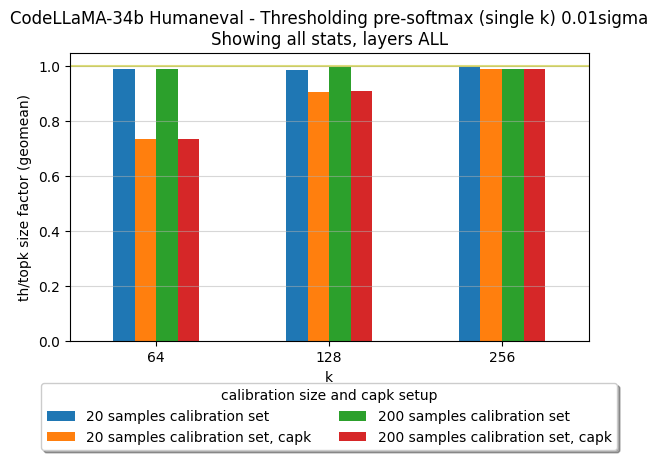

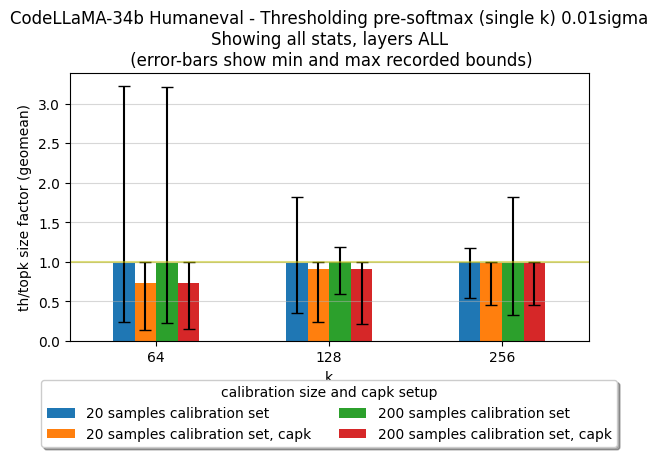

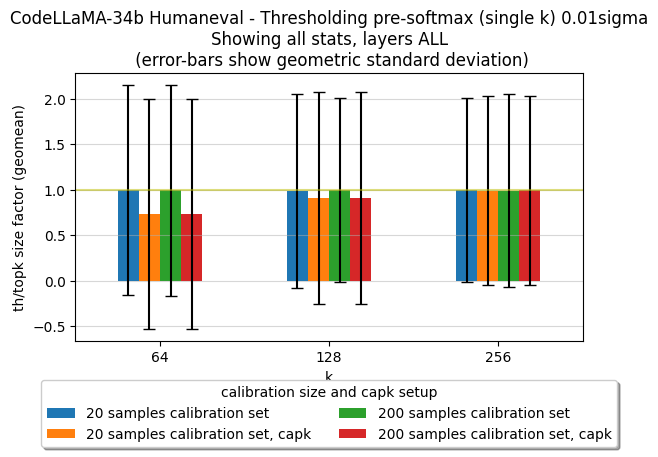

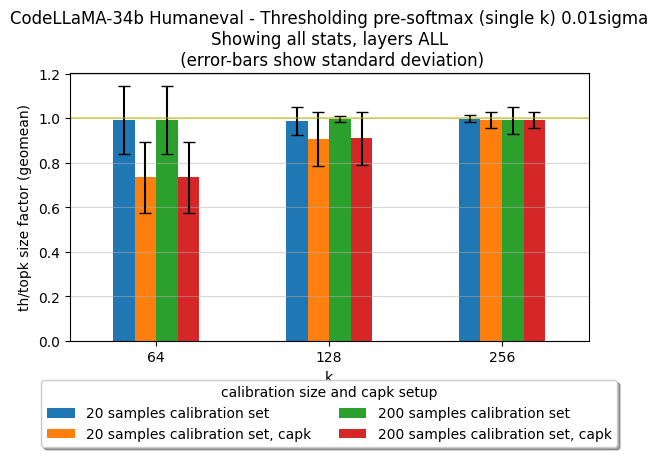

In [12]:

plt_cols = ['k','legend','th/topk size factor (geomean)',
            'th/topk size factor (geostd)',
            'th/topk size factor (min)',
            'th/topk size factor (max)',
            'th/topk size factor (std)']
unique_legends = df.legend.unique().tolist()

# mean sz_factor values (to be plotted as columns)
mean_df = df[plt_cols].drop(columns=['th/topk size factor (max)','th/topk size factor (min)','th/topk size factor (geostd)','th/topk size factor (std)']).pivot(index='k', columns='legend', values='th/topk size factor (geomean)').reset_index(drop=False)

# plot several options of errorbar vizualization (each on different image)
for errorbar in ["noerrorbars", "min_max", "geostd", "std"]:
    dump_size_barplot(mean_df, plt_cols, unique_legends, errorbar)



In [6]:
mean_df

legend,k,20 samples calibration set,"20 samples calibration set, capk",200 samples calibration set,"200 samples calibration set, capk"
0,64,0.991128,0.733991,0.991112,0.734939
1,128,0.987577,0.907413,0.998126,0.909236
2,256,0.997660,0.990341,0.989499,0.990820
